In [1]:
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt

In [2]:
print("OpenCV Version:\t",cv2.__version__)

OpenCV Version:	 3.4.3


In [3]:
def display_imgs(img_list, labels=[],cols=5, fig_size=(30,30)):
    cmap = None
    rows = len(img_list) / cols
    plt.figure(figsize=fig_size)
    plt.subplots_adjust(left=0.0,right=0.5,wspace=0.0,hspace=0.2)
    for i in range(len(img_list)):
        plt.subplot(rows, cols, i+1)
        if len(img_list[i].shape) == 2:
            cmap = 'gray'
        if len(labels) > 0:
            plt.title(labels[i])
        plt.imshow(img_list[i], cmap=cmap)
    #plt.tight_layout()
    plt.show()

In [4]:
single_ex = False
img_loc = ''
img_loc2 = ''
img_loc3 = ''
imgs = []
if(single_ex):
    img_loc = 'Vehicle_Detection/images/lanes_1.jpg' # Good example
    img_loc2 = 'Vehicle_Detection/images/input.jpg' # Curve Example 
    img_loc3 = 'datasets/vehicle/Sunny_LISA_3/Sunny_imgs/20191110215_1.png' # Non-working example
else:
    loc = 'datasets/udacity_challenge_video/challenge_frames/'
    for f in os.listdir(loc):
        img = cv2.imread(loc + f)
        imgs.append(img)

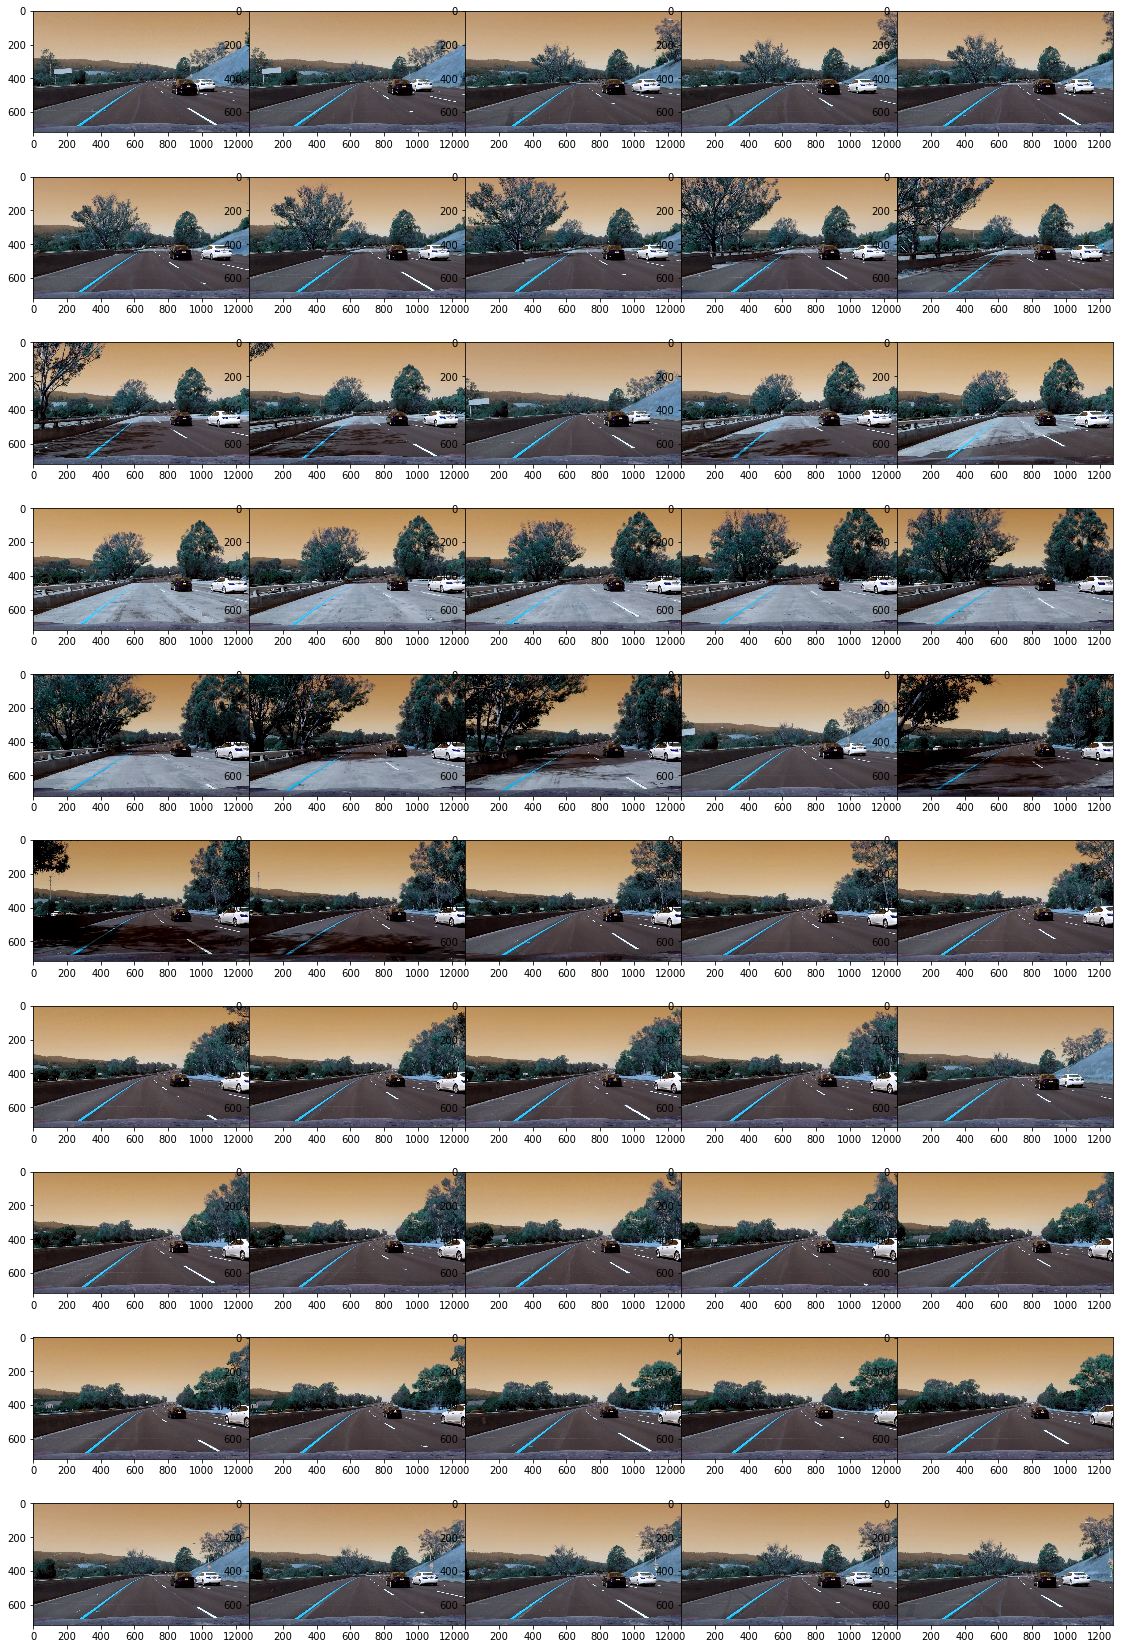

In [5]:
if(single_ex):
    img = cv2.imread(img_loc)
    plt.imshow(img)
else:
    display_imgs(imgs)

In [6]:
hls_im = None
hls_imgs = []
if(single_ex):
    hls_im = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    plt.imshow(hls_im)
else:
    for im in imgs:
        hls_im = cv2.cvtColor(im,cv2.COLOR_BGR2HLS)
        hls_imgs.append(hls_im)

In [7]:
w_lower_b = np.array([0, 200, 0], dtype=np.uint8)
w_upper_b = np.array([200, 255, 255], dtype=np.uint8)
y_lower_b = np.array([10, 0, 100], dtype=np.uint8)
y_upper_b = np.array([40, 255, 255], dtype=np.uint8)

In [8]:
# Yellow Lanes
yellow_mask = None
yellow_masks = []
if(single_ex):
    yellow_mask = cv2.inRange(hls_im,y_lower_b,y_upper_b)
    plt.imshow(yellow_mask)
else:
    for im in hls_imgs:
        yellow_mask = cv2.inRange(im,y_lower_b,y_upper_b) 
        yellow_masks.append(yellow_mask)

In [9]:
# White Lanes
white_mask = None
white_masks = []
if(single_ex):
    white_mask = cv2.inRange(hls_im,w_lower_b,w_upper_b)
    plt.imshow(white_mask)
else:
    for im in hls_imgs:
        white_mask = cv2.inRange(hls_im,w_lower_b,w_upper_b)
        white_masks.append(white_mask)


In [10]:
# Both types of lanes
combined_mask = None
combined_masks = []
if(single_ex):
    combined_mask = cv2.bitwise_or(yellow_mask,white_mask)
    plt.imshow(combined_mask)
else:
    for y_mask,w_mask in zip(yellow_masks,white_masks):
        combined_mask = cv2.bitwise_or(y_mask,w_mask)
        combined_masks.append(combined_mask)

In [11]:
# Blur Masked Image
blurred_mask = None
blurred_masks = []
if(single_ex):
    blurred_mask = cv2.GaussianBlur(combined_mask,(7,7),0)
    plt.imshow(blurred_mask)
else:
    for im in combined_masks:
        blurred_mask = cv2.GaussianBlur(im,(7,7),0)
        blurred_masks.append(blurred_mask)

In [12]:
edges = None
edges_ims = []
if(single_ex):
    edges = cv2.Canny(blurred_mask,100,190)
    plt.figure(figsize = (50,10))
    plt.imshow(edges,interpolation='nearest')
else:
    for im in blurred_masks:
        edges = cv2.Canny(im,100,190)
        edges_ims.append(edges)

In [13]:
def get_lanes(roi_im):
    lines = cv2.HoughLinesP(roi_im,rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)
    return lines

def draw_lines(image,lines):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image,(x1,y1),(x2,y2),color=[255, 0, 0],thickness=2)
    return image

if(single_ex):
    lines = get_lanes(edges)
    image = draw_lines(lines)
    plt.figure(figsize = (50,10))
    plt.imshow(image)
# else:
#     last = None
#     for im,edges in zip(imgs,edges_ims):
#         lines = get_lanes(edges)
#         image = draw_lines(im,lines)
#         last = image
#     plt.figure(figsize = (50,10))
#     plt.imshow(last)

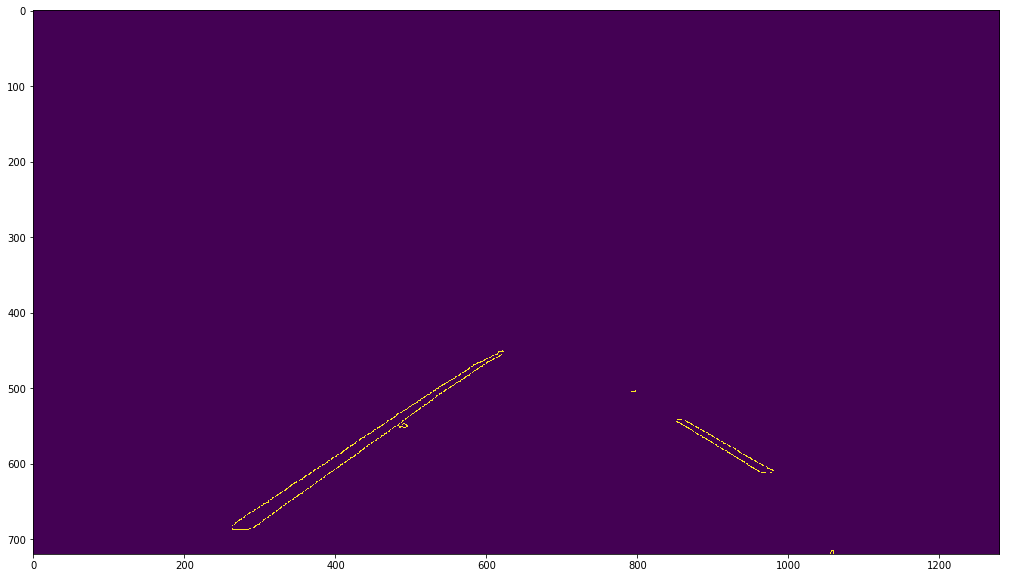

In [14]:
plt.close()
# Get ROI
def get_roi(img):
    rows, cols = img.shape[:2]
    #print('img rows={} --- img cols={}'.format(rows,cols))
    mask = np.zeros_like(img)
    
    #print(mask)
    
    left_bottom = np.array([int(cols * 0), int(rows)])
    right_bottom = np.array([int(cols * 1), int(rows)])
    left_top = np.array([int(cols * 0.47),int(rows * 0.6)])
    right_top = np.array([int(cols * 0.50), int(rows * 0.6)])
    
#     print(left_bottom)
#     print(right_bottom)
#     print(left_top)
#     print(right_top)
    w = right_top[0] - left_top[0]
    h = left_bottom[1] - left_top[1]
    #print("w = ",w)
    #print("h = ",h)
    #cv2.line(img,tuple(left_bottom),tuple(right_top),color=[255, 0, 0],thickness=2)
    #cv2.line(img,tuple(left_top),tuple(right_bottom),color=[255, 0, 0],thickness=2)
    #cv2.rectangle(img,tuple(left_top),(left_top[0]+w,left_top[1]+h),color=[255, 0, 0],thickness=2)
    
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255, ) * mask.shape[2])
    return cv2.bitwise_and(img, mask)


roi_im = None
roi_imgs = []

if(single_ex):
    roi_im = get_roi(test)
    plt.figure(figsize = (50,10))
    plt.imshow(roi_im)
else:
    last = None
    for im in edges_ims:
        roi = get_roi(im)
        roi_imgs.append(roi)
        last = roi
    plt.figure(figsize = (50,10))
    plt.imshow(last)

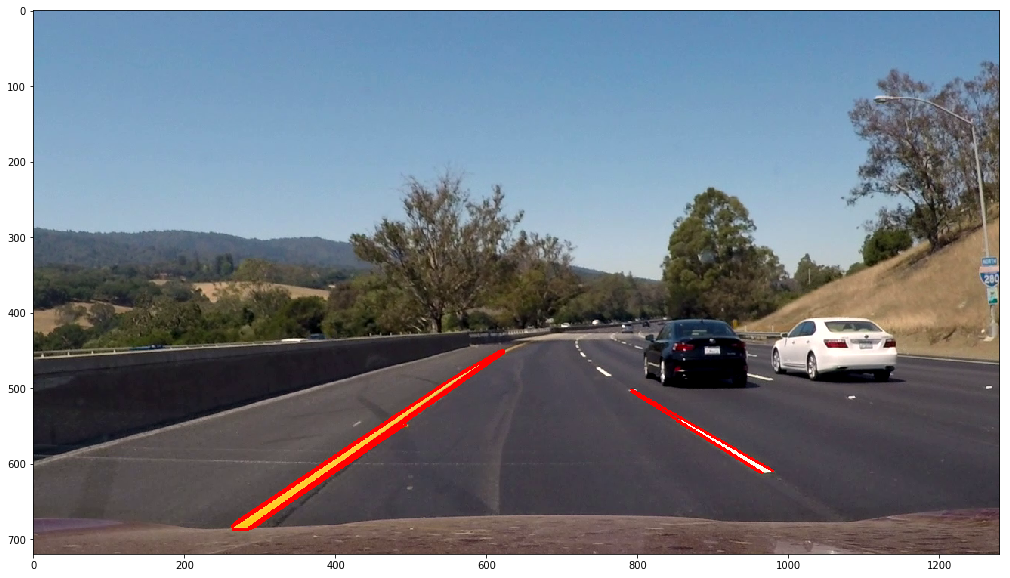

In [15]:
rgb_im = None
lines = None
predicted_lanes = []

if(single_ex):
    rgb_im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    lines = get_lanes(roi_im)
    rgb_im = draw_lines(rgb_im,lines)

    plt.figure(figsize = (50,10))
    plt.imshow(rgb_im)
else:
    last = None
    for bgr_im,roi_edges in zip(imgs,roi_imgs):
        rgb_im = cv2.cvtColor(bgr_im,cv2.COLOR_BGR2RGB)
        lines = get_lanes(roi_edges)
        pred = draw_lines(rgb_im,lines)
        last = pred
        predicted_lanes.append(pred)
    plt.figure(figsize = (50,10))
    plt.imshow(last)

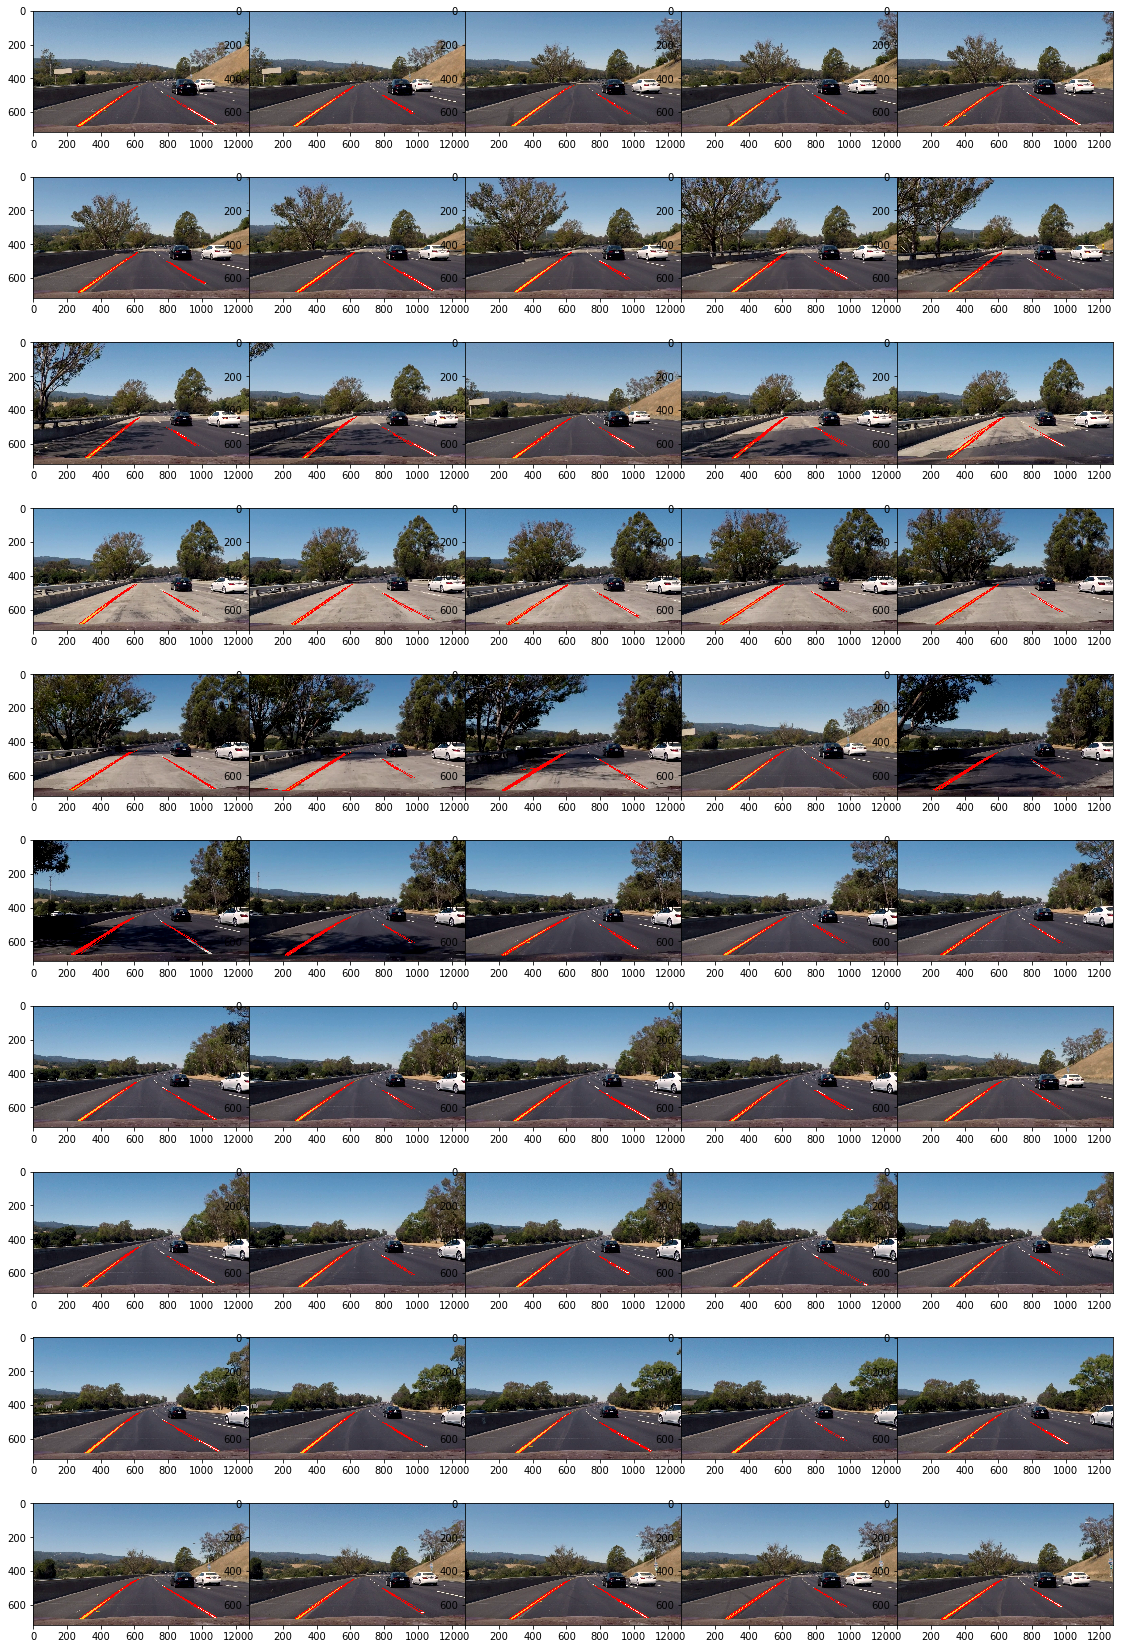

In [16]:
display_imgs(predicted_lanes)